<center><h1>Projet Robotique</h1></center>
<center><h2>Classification via le Machine learning</h2></center>

# Importation des librairies

In [3]:
!pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from bayes_opt import BayesianOptimization

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Importation du dataset

In [2]:
df = pd.read_csv('preprocessed_data.csv')

df

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LUA^ accY,Accelerometer LUA^ accZ,...,LOCATION TAG4 X,LOCATION TAG4 Y,LOCATION TAG4 Z,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.146747,0.337532,-1.410530,0.693260,0.434434,0.074936,-0.199117,0.621667,-0.455638,...,0.147947,0.811792,0.186199,0,0,0,0,0,0,0
1,-1.585185,0.263802,0.342378,-1.626921,0.626338,0.487110,0.200034,-0.108635,0.598101,-0.542260,...,0.147947,0.812691,0.178270,0,0,0,0,0,0,0
2,-1.585083,0.194202,0.371457,-1.735116,0.470187,0.527630,0.179184,-0.099275,0.709202,-0.572130,...,0.147947,0.814490,0.172322,0,0,0,0,0,0,0
3,-1.584985,0.058164,0.153369,-1.616313,0.618902,0.523578,0.210459,-0.152316,0.729402,-0.593039,...,0.147947,0.816289,0.172322,0,0,0,0,0,0,0
4,-1.584886,0.247984,0.290684,-1.705415,0.570570,0.535734,0.161809,-0.189757,0.709202,-0.634857,...,0.149055,0.818988,0.176287,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.407215,0.640278,0.298761,-0.141884,0.358651,0.102168,0.787298,0.418657,0.540867,-0.067329,...,0.129671,0.139901,0.208006,0,0,0,0,0,0,0
606044,1.407317,0.437804,0.297145,-0.020960,0.291729,0.102168,0.776873,0.452977,0.483633,-0.195770,...,0.129117,0.138102,0.206023,0,0,0,0,0,0,0
606045,1.407416,0.678242,0.240604,-0.001866,0.143014,0.110272,0.915871,0.393696,0.503833,-0.195770,...,0.129117,0.136303,0.202059,0,0,0,0,0,0,0
606046,1.407514,1.155955,0.159831,-0.046417,0.098399,0.256145,0.780348,0.362495,0.577900,-0.276418,...,0.129671,0.134504,0.200076,0,0,0,0,0,0,0


# Fonctions diverses

# Fonctions de feature selection

In [3]:
def dim_reduction(df, n):
  pca = PCA(n_components=n)
  pca.fit(df)
  reducted_df = pca.fit_transform(df)
  columns_name = ['column'+str(i) for i in range(1, pca.n_components_+1)]
  return pd.DataFrame(reducted_df, columns=columns_name)


In [4]:
def correlation(dataset, cor):
    df = dataset.copy()
    col_corr = set()  # For storing unique value
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > cor: # absolute values to handle positive and negative correlations
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    df.drop(col_corr,axis = 1,inplace = True)
    return df

## Fonction de segmentation du dataset  

In [5]:
def data_segmentation(dataCollection, window_size, label): # segment the data and create a dataset with locomotion classes as labels

    loco_i = dataCollection.columns.get_loc(label)
    #convert the data frame to numpy array
    data = dataCollection.to_numpy()
    #segment the data
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0

    while start + window_size - 1 < n:
        end = start + window_size-1
        if data[start][loco_i] == data[end][loco_i] and data[start][-1] == data[end][-1] : # if the frame contains the same activity and from the file
            X.append(data[start:(end+1),:])
            y.append(data[start][loco_i])
            start += window_size//2 # 50% overlap
        else: # if the frame contains different activities or from different objects, find the next start point
            while start + window_size-1 < n:
                if data[start][loco_i] != data[start+1][loco_i]:
                    break
                start += 1
            start += 1

    return np.asarray(X), np.asarray(y)

# Modèles de machine learning

## Logistic Regression

In [6]:
def my_logistic_regression(X_train, y_train, C):
    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)
    return model

In [7]:
def pipeline_lr(method, tresh, C):
         
    if method <= 1:
        dataset = dim_reduction(df[df.columns[:-7]], tresh)
    elif method <= 2:
        dataset = correlation(df[df.columns[:-7]], tresh)

    labels = df[df.columns[-7:]]
    dataset = pd.concat([dataset, labels], axis=1)

    X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')
    X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)
    
    model = my_logistic_regression(X_train, y_train, C)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [8]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    'C': (0, 10)
    }


optimizer = BayesianOptimization(
    f=pipeline_lr,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   |     C     |  method   |   tresh   |
-------------------------------------------------------------
| 1         | 1.0       | 4.17      | 1.441     | 0.1001    |
| 2         | 0.9988    | 3.023     | 0.2935    | 0.1822    |
| 3         | 1.0       | 1.863     | 0.6911    | 0.4531    |
| 4         | 0.9976    | 5.388     | 0.8384    | 0.7098    |
| 5         | 1.0       | 2.045     | 1.756     | 0.1244    |
| 6         | 1.0       | 6.705     | 0.8346    | 0.5972    |
| 7         | 0.9976    | 1.404     | 0.3962    | 0.8127    |
| 8         | 0.9976    | 9.683     | 0.6268    | 0.7162    |
| 9         | 1.0       | 8.764     | 1.789     | 0.1757    |
| 10        | 0.9976    | 0.3905    | 0.3397    | 0.8815    |
| 11        | 0.9976    | 3.758     | 1.58      | 0.7893    |
| 12        | 1.0       | 5.323     | 1.575     | 0.2557    |
| 13        | 0.9976    | 5.958     | 0.522     | 0.7646    |
| 14        | 0.9976    | 2.275     | 0.3112    | 0.9431    |
| 15    

In [10]:
method = optimizer.max['params']['method']
tresh = optimizer.max['params']['tresh']
C = optimizer.max['params']['C']

if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)

# Create an instance of the logistic regression classifier
clf = my_logistic_regression(X_train, y_train, C)

# Predict the labels for the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


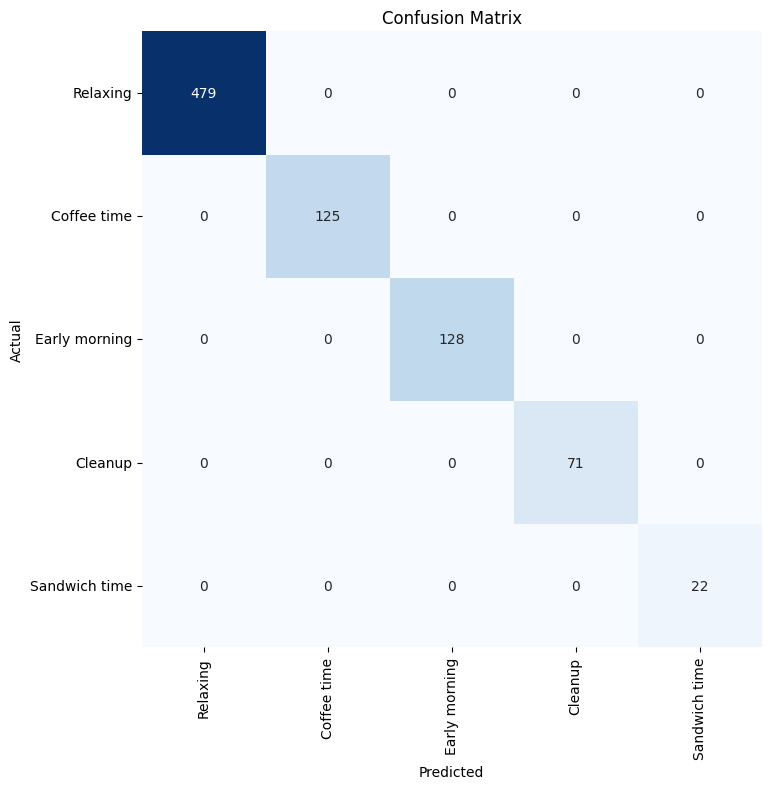

In [11]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## KNN

In [12]:
def my_knn(X_train, y_train, n_neighbors):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    return model

In [13]:
def pipeline_knn(method, tresh, n_neighbors):
         
    if method <= 1:
        dataset = dim_reduction(df[df.columns[:-7]], tresh)
    elif method <= 2:
        dataset = correlation(df[df.columns[:-7]], tresh)

    labels = df[df.columns[-7:]]
    dataset = pd.concat([dataset, labels], axis=1)

    X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')
    X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)
    
    model = my_knn(X_train, y_train, int(n_neighbors))
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [14]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    'n_neighbors': (1, 20)
    }


optimizer = BayesianOptimization(
    f=pipeline_knn,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   |  method   | n_neig... |   tresh   |
-------------------------------------------------------------
| 1         | 0.9285    | 0.834     | 14.69     | 0.1001    |
| 2         | 0.9673    | 0.6047    | 3.788     | 0.1822    |
| 3         | 0.9515    | 0.3725    | 7.566     | 0.4531    |
| 4         | 0.9624    | 1.078     | 8.965     | 0.7098    |
| 5         | 0.9236    | 0.4089    | 17.68     | 0.1244    |
| 6         | 0.9661    | 1.341     | 8.929     | 0.5972    |
| 7         | 0.9818    | 0.2808    | 4.764     | 0.8127    |
| 8         | 0.9697    | 1.937     | 6.955     | 0.7162    |
| 9         | 0.9285    | 1.753     | 18.0      | 0.1757    |
| 10        | 0.983     | 0.07811   | 4.227     | 0.8815    |
| 11        | 0.9939    | 0.08965   | 1.047     | 0.9469    |
| 12        | 0.9952    | 2.0       | 1.0       | 0.99      |
| 13        | 0.9891    | 1.108     | 1.048     | 0.1134    |
| 14        | 0.9927    | 2.0       | 2.519     | 0.99      |
| 15    

In [15]:
method = optimizer.max['params']['method']
tresh = optimizer.max['params']['tresh']
n_neighbors = optimizer.max['params']['n_neighbors']

if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)

# Create an instance of the KNN classifier
clf = my_knn(X_train, y_train, int(n_neighbors))

# Predict the labels for the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9963636363636363
Precision: 0.9964488636363636
Recall: 0.9963636363636363
F1 Score: 0.9963794842659152


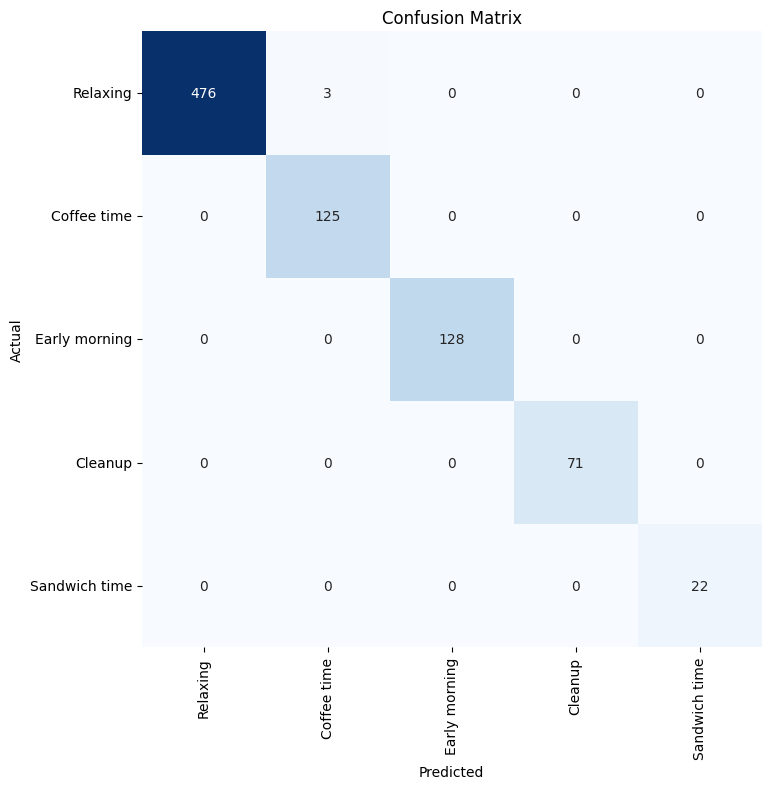

In [16]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Naive Bayes

In [17]:
def my_naive_bayes(X_train, y_train):
    model = GaussianNB()
    model.fit(X_train, y_train)
    return model

In [18]:
def pipeline_naive_bayes(method, tresh):
         
    if method <= 1:
        dataset = dim_reduction(df[df.columns[:-7]], tresh)
    elif method <= 2:
        dataset = correlation(df[df.columns[:-7]], tresh)

    labels = df[df.columns[-7:]]
    dataset = pd.concat([dataset, labels], axis=1)

    X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')
    X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)
    
    model = my_naive_bayes(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [19]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    }


optimizer = BayesianOptimization(
    f=pipeline_naive_bayes,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   |  method   |   tresh   |
-------------------------------------------------
| 1         | 1.0       | 0.834     | 0.7411    |
| 2         | 1.0       | 0.0002287 | 0.3691    |
| 3         | 1.0       | 0.2935    | 0.1822    |
| 4         | 1.0       | 0.3725    | 0.4075    |
| 5         | 1.0       | 0.7935    | 0.5795    |
| 6         | 1.0       | 0.8384    | 0.7098    |
| 7         | 1.0       | 0.4089    | 0.8815    |
| 8         | 1.0       | 0.05478   | 0.6967    |
| 9         | 1.0       | 0.8346    | 0.5972    |
| 10        | 1.0       | 0.2808    | 0.2763    |
| 11        | 1.0       | 1.994     | 0.9846    |
| 12        | 1.0       | 1.999     | 0.1307    |
| 13        | 1.0       | 1.998     | 0.1192    |
| 14        | 1.0       | 2.0       | 0.9659    |
| 15        | 1.0       | 1.998     | 0.1082    |
| 16        | 1.0       | 1.999     | 0.9809    |
| 17        | 1.0       | 0.005558  | 0.9739    |
| 18        | 1.0       | 1.997     | 0.1096    |


In [20]:
method = optimizer.max['params']['method']
tresh = optimizer.max['params']['tresh']

if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)

# Create an instance of the Naive Bayes classifier
clf = my_naive_bayes(X_train, y_train)

# Predict the labels for the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


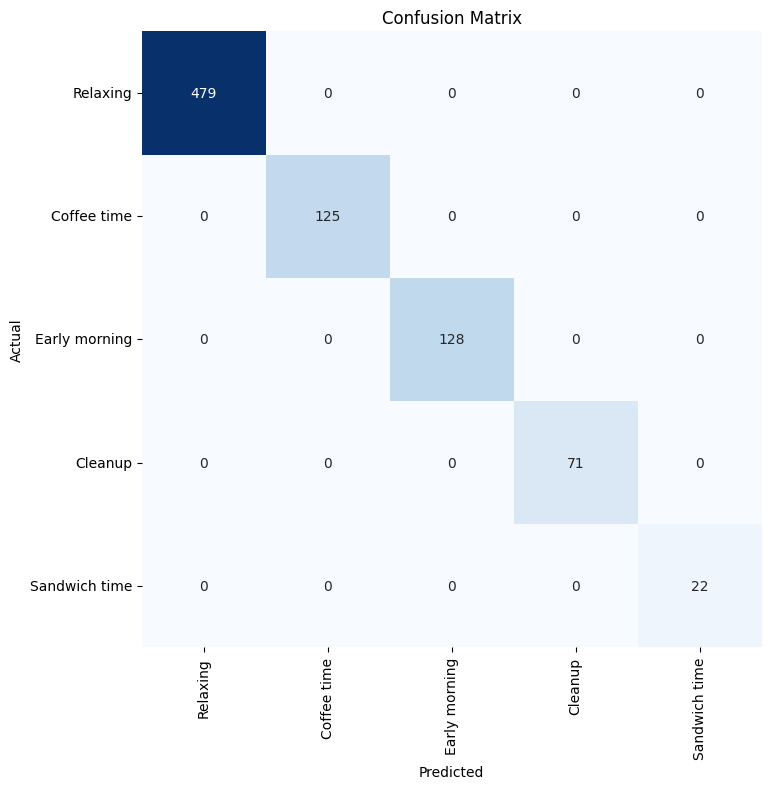

In [21]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# QDA

In [22]:
def my_qda(X_train, y_train):
    model = QuadraticDiscriminantAnalysis()
    model.fit(X_train, y_train)
    return model

In [23]:
def pipeline_qda(method, tresh):
         
    if method <= 1:
        dataset = dim_reduction(df[df.columns[:-7]], tresh)
    elif method <= 2:
        dataset = correlation(df[df.columns[:-7]], tresh)

    labels = df[df.columns[-7:]]
    dataset = pd.concat([dataset, labels], axis=1)

    X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')
    X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)
    
    model = my_qda(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [24]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    }


optimizer = BayesianOptimization(
    f=pipeline_qda,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   |  method   |   tresh   |
-------------------------------------------------
| 1         | 1.0       | 0.834     | 0.7411    |
| 2         | 0.08606   | 0.0002287 | 0.3691    |
| 3         | 0.08606   | 0.2935    | 0.1822    |
| 4         | 1.0       | 0.3725    | 0.4075    |
| 5         | 1.0       | 0.7935    | 0.5795    |
| 6         | 1.0       | 0.8384    | 0.7098    |
| 7         | 1.0       | 0.4089    | 0.8815    |
| 8         | 1.0       | 0.05478   | 0.6967    |
| 9         | 1.0       | 0.8346    | 0.5972    |
| 10        | 0.08606   | 0.2808    | 0.2763    |
| 11        | 1.0       | 0.4307    | 0.6159    |
| 12        | 1.0       | 0.06194   | 0.99      |
| 13        | 1.0       | 0.2986    | 0.6596    |
| 14        | 0.08606   | 0.8075    | 0.2011    |
| 15        | 1.0       | 1.167     | 0.99      |
| 16        | 1.0       | 1.377     | 0.6956    |
| 17        | 1.0       | 1.573     | 0.99      |
| 18        | 1.0       | 1.776     | 0.6577    |


In [25]:
method = optimizer.max['params']['method']
tresh = optimizer.max['params']['tresh']

if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)

# Create an instance of the QDA classifier
clf = my_qda(X_train, y_train)

# Predict the labels for the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


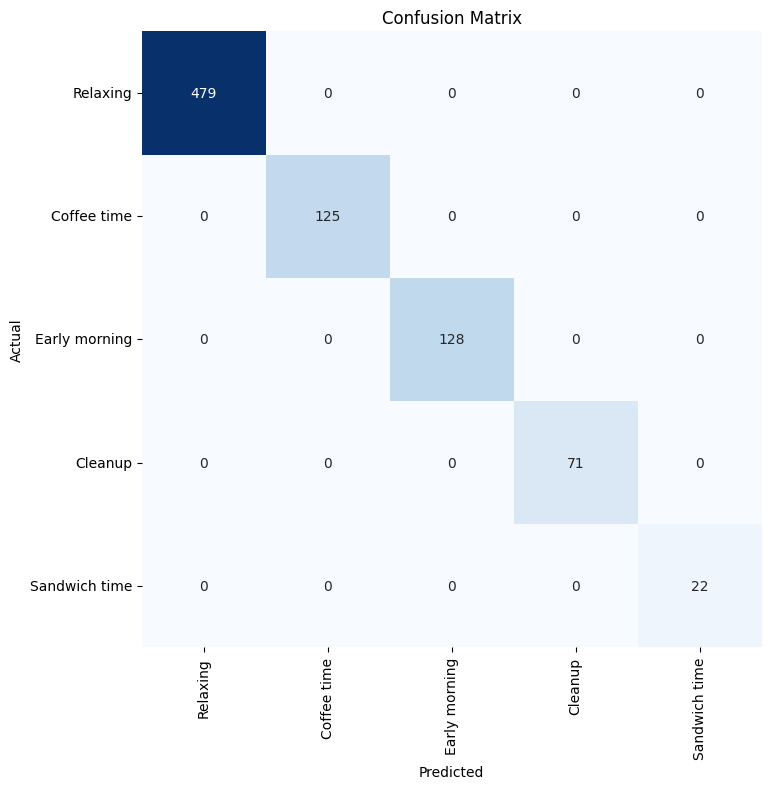

In [26]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Decision Tree

In [27]:
def my_decision_tree(X_train, y_train, max_depth, min_samples_split, min_samples_leaf):
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    return model

In [28]:
def pipeline_dt(method, tresh, max_depth, min_samples_split, min_samples_leaf):
     
    if method <= 1:
        dataset = dim_reduction(df[df.columns[:-7]], tresh)
    elif method <= 2:
        dataset = correlation(df[df.columns[:-7]], tresh)

    labels = df[df.columns[-7:]]
    dataset = pd.concat([dataset, labels], axis=1)

    X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')
    X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)

    model = my_decision_tree(X_train, y_train, max_depth=int(max_depth), min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf))
    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred)

In [29]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    'max_depth': (1, 32),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
    }


optimizer = BayesianOptimization(
    f=pipeline_dt,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   | max_depth |  method   | min_sa... | min_sa... |   tresh   |
-------------------------------------------------------------------------------------
| 1         | 1.0       | 13.93     | 1.441     | 1.001     | 4.419     | 0.2306    |
| 2         | 0.9733    | 3.862     | 0.3725    | 4.11      | 5.174     | 0.5795    |
| 3         | 1.0       | 14.0      | 1.37      | 2.84      | 9.025     | 0.1244    |
| 4         | 1.0       | 21.78     | 0.8346    | 6.028     | 3.123     | 0.2763    |
| 5         | 1.0       | 25.82     | 1.937     | 3.821     | 7.539     | 0.88      |
| 6         | 1.0       | 28.73     | 0.1701    | 1.351     | 3.359     | 0.8815    |
| 7         | 1.0       | 4.049     | 0.8422    | 9.621     | 6.265     | 0.7158    |
| 8         | 1.0       | 10.78     | 1.373     | 8.512     | 2.146     | 0.7676    |
| 9         | 1.0       | 31.65     | 1.496     | 3.524     | 8.314     | 0.1919    |
| 10        | 1.0       | 14.88     | 1.817     | 3.64

In [30]:
method = optimizer.max['params']['method']
tresh = optimizer.max['params']['tresh']
min_samples_split = optimizer.max['params']['min_samples_split']
min_samples_leaf = optimizer.max['params']['min_samples_leaf']
max_depth = optimizer.max['params']['max_depth']

if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)

# Create an instance of the decision tree classifier
clf = my_decision_tree(X_train, y_train, max_depth=int(max_depth), min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf))

# Predict the labels for the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


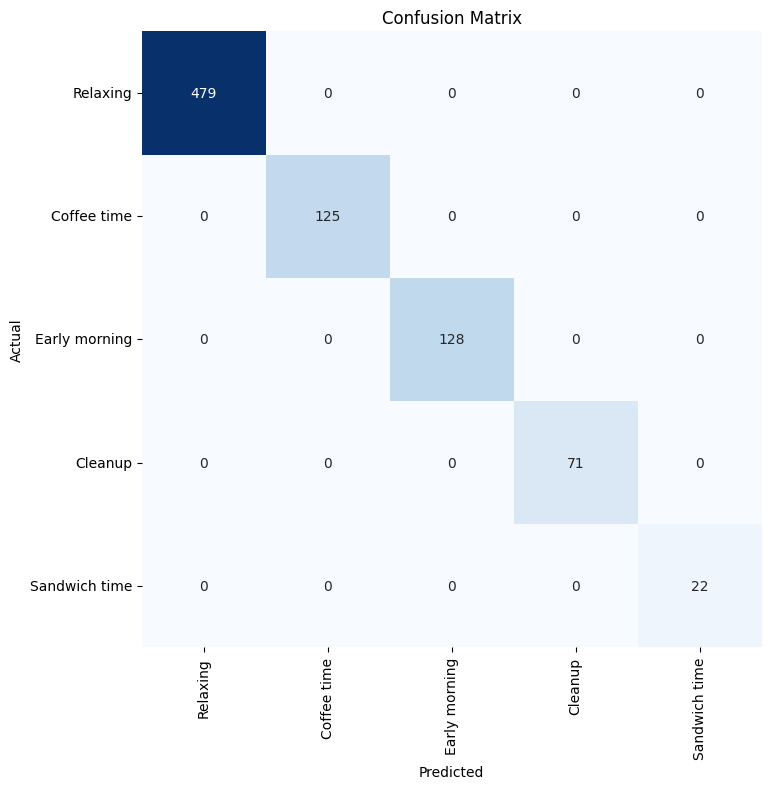

In [31]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Random Forest

In [32]:
def my_random_forest(X_train, y_train, n_estimators, max_depth, min_samples_split, min_samples_leaf):
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    return model

In [33]:
def pipeline_random_forest(method, tresh, n_estimators, max_depth, min_samples_split, min_samples_leaf):
     
    if method <= 1:
        dataset = dim_reduction(df[df.columns[:-7]], tresh)
    elif method <= 2:
        dataset = correlation(df[df.columns[:-7]], tresh)

    labels = df[df.columns[-7:]]
    dataset = pd.concat([dataset, labels], axis=1)

    X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')
    X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)

    model = my_random_forest(X_train, y_train, n_estimators=int(n_estimators), max_depth=int(max_depth), min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf))
    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred)

In [34]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    'n_estimators': (10, 100),
    'max_depth': (1, 32),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
    }


optimizer = BayesianOptimization(
    f=pipeline_random_forest,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   | max_depth |  method   | min_sa... | min_sa... | n_esti... |   tresh   |
-------------------------------------------------------------------------------------------------
| 1         | 1.0       | 13.93     | 1.441     | 1.001     | 4.419     | 23.21     | 0.1822    |
| 2         | 0.9758    | 6.774     | 0.6911    | 4.571     | 6.311     | 47.73     | 0.7098    |
| 3         | 0.9939    | 7.338     | 1.756     | 1.246     | 7.364     | 47.56     | 0.5972    |
| 4         | 0.9188    | 5.352     | 0.3962    | 8.207     | 9.746     | 38.21     | 0.7162    |
| 5         | 0.9976    | 28.17     | 1.789     | 1.765     | 2.312     | 25.28     | 0.8815    |
| 6         | 0.9491    | 4.049     | 0.8422    | 9.621     | 6.265     | 72.27     | 0.3808    |
| 7         | 0.9988    | 22.28     | 1.669     | 1.165     | 8.001     | 99.0      | 0.7659    |
| 8         | 1.0       | 9.694     | 1.579     | 1.929     | 5.583     | 91.77     | 0.3613    |
| 9         | 1.0   

In [35]:
method = optimizer.max['params']['method']
tresh = optimizer.max['params']['tresh']
n_estimators = optimizer.max['params']['n_estimators']
min_samples_split = optimizer.max['params']['min_samples_split']
min_samples_leaf = optimizer.max['params']['min_samples_leaf']
max_depth = optimizer.max['params']['max_depth']

if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)

# Create an instance of the SVM classifier
clf = my_random_forest(X_train, y_train, n_estimators=int(n_estimators), max_depth=int(max_depth), min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf))

# Predict the labels for the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


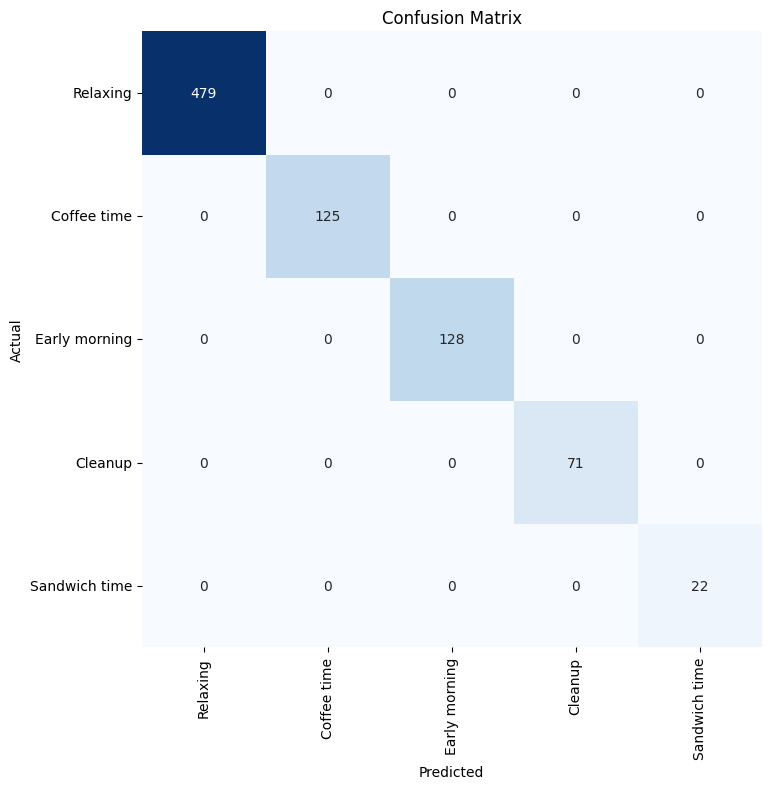

In [36]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## SVM

In [37]:
def my_svm(X_train, y_train, C, kernel, gamma):
    if kernel <= 1:
        k = 'linear'
    elif kernel <= 2:
        k = 'poly'
    elif kernel <= 3:
        k = 'rbf'
    elif kernel <= 4:
        k = 'sigmoid'
    model = svm.SVC(C=C, kernel=k, gamma=gamma)
    model.fit(X_train, y_train)
    return model

In [39]:
def pipeline_svm(method, tresh, C, kernel, gamma):

  if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
  elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

  labels = df[df.columns[-7:]]
  dataset = pd.concat([dataset, labels], axis=1)

  X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

  # split the data into train, validation and test sets using sklearn
  X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, shuffle=True, test_size=0.33)

  model = my_svm(X_train, y_train, C, kernel, gamma)

  y_pred = model.predict(X_test)

  return accuracy_score(y_test, y_pred)


In [40]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    'C': (0.1, 10),
    'kernel': (0, 4),
    'gamma': (0.1, 10)
    }


optimizer = BayesianOptimization(
    f=pipeline_svm,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   |     C     |   gamma   |  kernel   |  method   |   tresh   |
-------------------------------------------------------------------------------------
| 1         | 1.0       | 4.229     | 7.231     | 0.0004575 | 0.6047    | 0.2306    |
| 2         | 0.9882    | 1.014     | 1.944     | 1.382     | 0.7935    | 0.5795    |
| 3         | 1.0       | 4.25      | 6.884     | 0.8178    | 1.756     | 0.1244    |
| 4         | 0.6047    | 6.738     | 4.231     | 2.235     | 0.2808    | 0.2763    |
| 5         | 0.9934    | 8.027     | 9.686     | 1.254     | 1.385     | 0.88      |
| 6         | 0.9993    | 8.957     | 0.9419    | 0.1562    | 0.3397    | 0.8815    |
| 7         | 0.5107    | 1.074     | 4.269     | 3.832     | 1.066     | 0.7158    |
| 8         | 0.5518    | 3.224     | 6.896     | 3.339     | 0.03658   | 0.7676    |
| 9         | 0.9934    | 9.89      | 7.507     | 1.122     | 1.579     | 0.1919    |
| 10        | 0.9971    | 4.534     | 9.095     | 1.17

In [44]:
method = optimizer.max['params']['method']
tresh = optimizer.max['params']['tresh']
C = optimizer.max['params']['C']
gamma = optimizer.max['params']['gamma']
kernel = optimizer.max['params']['kernel']

if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.mean(axis=1), y, test_size=0.2, random_state=42)

# Create an instance of the SVM classifier
clf = svm.SVC()

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels for the testing data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


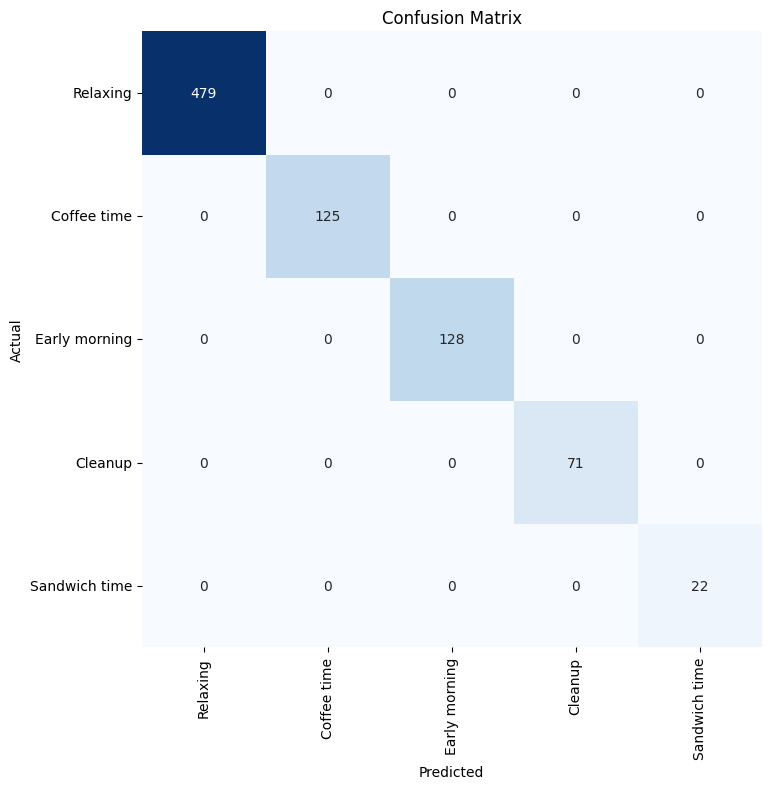

In [47]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()